In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
from lmfit import Model,Parameter,Parameters
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import os
from functions import plot_preprocessed_dist,plot_track_characteristics,mmsd_plot,cutoff_function,msd,data_pool,two_distributions_plot,partition,ecdf,kolmogorov_smirnov,compute_mean_intensity_map,KS_MAP,KS_MAP_2SAMP
from celluloid import Camera
%matplotlib inline
%reload_ext autoreload

# Multi experiment comparisons

We want to be able to compare distributions of the diffusion coefficient in different experiments. The `data_pool` function generates a matrix containing $\alpha$, $D$, $c$, $N$, the track ID, $x$ and $y$ arrays, and the cell activity $I$ (if images are provided) for a track that survives the `minframe`, `maxframe` and `rsquared_threshold` filters in all the files combined. 

In [72]:
dt = 0.05
minframe=5
maxframe=500
rsquared_threshold=0.7

files1 = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]
images1 = ["Data/SM1/sm1_stack.tif","Data/SM2/sm2_stack.tif","Data/SM3/sm3_stack.tif","Data/SM4/sm4_stack.tif","Data/SM5/sm5_stack.tif","Data/SM6/sm6_stack.tif","Data/SM7/sm7_stack.tif","Data/SM8/sm8_stack.tif","Data/SM9/sm9_stack.tif","Data/SM10/sm10_stack.tif"]

files2 = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]
images2 = ["Data/SM1_WNT/sm1_wnt_stack.tif","Data/SM2_WNT/sm2_wnt_stack.tif","Data/SM3_WNT/sm3_wnt_stack.tif","Data/SM4_WNT/sm4_wnt_stack.tif","Data/SM5_WNT/sm5_wnt_stack.tif","Data/SM6_WNT/sm6_wnt_stack.tif","Data/SM7_WNT/sm7_wnt_stack.tif","Data/SM8_WNT/sm8_wnt_stack.tif","Data/SM10_WNT/sm10_wnt_stack.tif"]

#files = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv"]
DATA1 = data_pool(files1,dt,minframe,maxframe,rsquared_threshold,images=images1,fit_option="thirty_percent")
DATA2 = data_pool(files2,dt,minframe,maxframe,rsquared_threshold,images=images2,fit_option="thirty_percent")

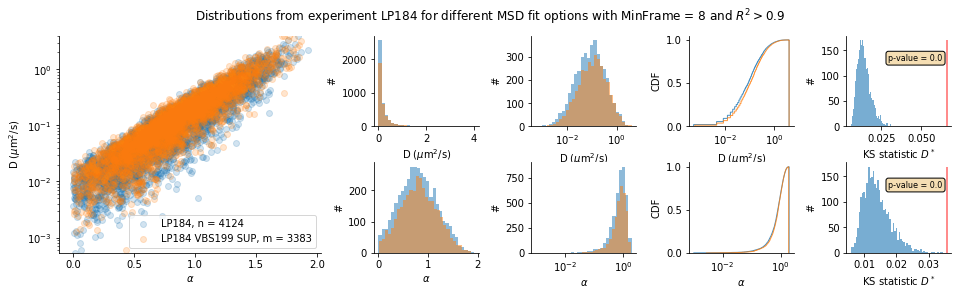

In [10]:
two_distributions_plot(DATA1,DATA2,"LP184",'LP184 VBS199 SUP',ksloop=3000,title=r'Distributions from experiment LP184 for different MSD fit options with MinFrame = '+str(minframe)+' and $R^2 >$'+str(rsquared_threshold))

### Kolmogorov - Smirnov test

We can compare the two distirbutions by performing a Kolmogorov-Smirnov test. This test looks for the maximum distance between the two cumulative distribution functions of these distributions. It returns a statistic number $D$ and evaluates a p-value. 

For some reason, in automatic mode `ks_2samp` does not evaluate properly the p-value. I assume that the `scipy` function performs a continuous fit of the statistical distribution of the $D$ statistic. Indeed, the pvalue can be evaluated experimentally by:
* concatenating the two distributions and shuffling the resulting large distribution
* splitting this large distribution into two partition respecting the size of the original distributions
* performing a two sample K-S test and obtaining $D^*$
* doing the previous steps $N$ times and counting how many times $D^* > D$, i.e. a measure of how much the directly computed $D$ is inside the statistical distribution of $D^*$. 

This probability of $D^* > D$ is the p-value. If it is 0 then all $D^*$ values are below $D$, there is no overlap, the distributions are in all likelihood different. If it is larger than 0.05 then there is at least a 5% chance that the original distributions are identical.

In [ ]:
dist1 = D_WNT
dist2 = D_LP184

stat,pvalue = kolmogorov_smirnov(dist1,dist2,1000,plot=True)

# Phase portraits with filter

We now use one feature from each dataset ($\alpha$, $c$, the cell activity) to filter out another feature, namely $D$. Once we have several filtered $D$-distribution, we can apply KS tests to compare their shapes. 

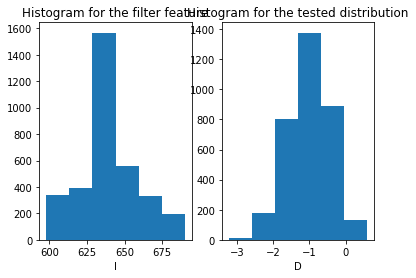

KS statistic =  0.0
bootstrap p-value =  1.0
KS statistic =  0.1065928270042194
bootstrap p-value =  0.0003333333333333333
KS statistic =  0.17589599385941607
bootstrap p-value =  0.0
KS statistic =  0.1470747389865037
bootstrap p-value =  0.0
KS statistic =  0.2018743667679838
bootstrap p-value =  0.0
KS statistic =  0.3039377289377289
bootstrap p-value =  0.0
KS statistic =  0.0
bootstrap p-value =  1.0
KS statistic =  0.09317177678200067
bootstrap p-value =  0.0003333333333333333
KS statistic =  0.08175274712877095
bootstrap p-value =  0.004333333333333333
KS statistic =  0.13743218806509946
bootstrap p-value =  0.0
KS statistic =  0.21700746510873092
bootstrap p-value =  0.0
KS statistic =  0.0
bootstrap p-value =  1.0
KS statistic =  0.06251678375233315
bootstrap p-value =  0.012333333333333333
KS statistic =  0.06617019392210327
bootstrap p-value =  0.071
KS statistic =  0.13540623460028295
bootstrap p-value =  0.001
KS statistic =  0.0
bootstrap p-value =  1.0
KS statistic =  0.

In [5]:
phase_portrait,windows = KS_MAP(DATA2,6,filter_dist='I',dist_for_ks='D',ksloops=3000)
#phase_portrait,windows = KS_MAP_2SAMP(DATA1,DATA2,10,filter_dist='C',dist_for_ks='D',ksloops=1000)

In [1]:
import seaborn as sns

heat_map = sns.heatmap(phase_portrait.round(decimals=2), linewidths=.1, annot=True, xticklabels=[round(a,2) for a in windows], yticklabels=[round(a,2) for a in windows])
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xlabel(r'cell activity window')
plt.ylabel(r'cell activity window')
plt.show() # ta-da!

NameError: name 'phase_portrait' is not defined

In [ ]:
%matplotlib notebook

data_pool
D1 = []
for k in range(np.shape(DATA1)[0]):
    D1.append(np.log10(DATA1[k][1]))
    
A1 = []
for k in range(np.shape(DATA1)[0]):
    A1.append(DATA1[k][0])
    
C1 = []
for k in range(np.shape(DATA1)[0]):
    C1.append(DATA1[k][2])

from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(D1, A1, C1,alpha=0.01)
ax.set_xlabel('D')
ax.set_ylabel(r'$\alpha$')
ax.set_zlabel('c')
plt.show()

# Mann-Whitney U test



In [37]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

#files1 = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]
#files2 = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]

files1 = ["Data/SM1/sm1_ld400.csv","Data/SM4/sm4_ld400.csv"]
files2 = ["Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv"]
DATA1 = data_pool(files1,dt,minframe,maxframe,rsquared_threshold,fit_option="thirty_percent")
DATA2 = data_pool(files2,dt,minframe,maxframe,rsquared_threshold,fit_option="thirty_percent")


D1 = []
for k in range(np.shape(DATA1)[0]):
    D1.append(np.log10(DATA1[k][1]))
    
D2 = []
for k in range(np.shape(DATA2)[0]):
    D2.append(np.log10(DATA2[k][1]))

# compare samples
stat, p = mannwhitneyu(D1, D2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=173187.000, p=0.001
Different distribution (reject H0)
